In [ ]:
!pip install torch torchvision matplotlib wandb tqdm
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=b92d3be5997fd5d18f566849d561bbd704098fcad6f8308ac52c18c693b905c5
  Stored in directory: /root/.cache/pip/wheels/f0/3f/76/8783033e8524d407e1bebaf72fdd3f3eba27e0c030e92bbd87
Successfully built chess


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files
import seaborn as sns


In [ ]:
import chess

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.scale = hidden_size ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        energy = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(attention, V)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = torch.relu(x)
        return x

class ChessDataset(Dataset):
    def __init__(self, json_file):
        with open(json_file, 'r') as f:
            self.sequences = json.load(f)

        self.positions = []

        for sequence in self.sequences:
            for position in sequence:
                if 'position' in position and 'next_move' in position:
                    position_tensor = torch.FloatTensor(position['position']).permute(2, 0, 1)
                    self.positions.append({
                        'position': position_tensor,
                        'next_move': position['next_move']
                    })

        moves = [pos['next_move'] for pos in self.positions]
        unique_moves = sorted(list(set(moves)))
        self.move_mapping = {move: idx for idx, move in enumerate(unique_moves)}
        print(f"Total positions: {len(self.positions)}")
        print(f"Unique moves: {len(unique_moves)}")

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        pos_data = self.positions[idx]
        move_idx = self.move_mapping[pos_data['next_move']]
        target = torch.zeros(len(self.move_mapping))
        target[move_idx] = 1
        return pos_data['position'], target

class ChessModel(nn.Module):
    def __init__(self, num_moves):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(13, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Added max pooling

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.policy_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 512),  # Adjusted for downscaling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_moves)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        policy = self.policy_head(x)
        return torch.log_softmax(policy, dim=1), None

class Visualizer:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.move_accuracies = []

    def update(self, train_loss, val_loss, move_accuracy):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.move_accuracies.append(move_accuracy)

    def plot(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.move_accuracies, 'g-')
        plt.title('Move Prediction Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')

        plt.tight_layout()
        plt.show()

def train_model(model, train_loader, num_epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

    model = model.to(device)
    visualizer = Visualizer()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_moves = 0
        total_moves = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for positions, targets in progress_bar:
            positions = positions.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs, _ = model(positions)
            loss = criterion(outputs, torch.argmax(targets, dim=1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate move accuracy
            pred_moves = torch.argmax(outputs, dim=1)
            true_moves = torch.argmax(targets, dim=1)
            correct_moves += (pred_moves == true_moves).sum().item()
            total_moves += targets.size(0)

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = train_loss / len(train_loader)
        accuracy = 100 * correct_moves / total_moves

        # Update visualizer with training metrics
        visualizer.update(avg_loss, avg_loss, accuracy)

        # Plot every 5 epochs
        if (epoch + 1) % 5 == 0:
            visualizer.plot()
            print(f'Epoch {epoch+1}:')
            print(f'Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%')

    # Save final model
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'final_loss': avg_loss,
    }, 'chess_model_final.pth')



In [ ]:
def main():
    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load dataset
    dataset = ChessDataset(json_filename)

    # Create dataloader for all data
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    print(f"Training on {len(dataset)} positions")
    print(f"Total number of unique moves: {len(dataset.move_mapping)}")

    # Initialize model and visualizer
    model = ChessModel(num_moves=len(dataset.move_mapping))
    visualizer = Visualizer()

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )
    model = model.to(device)

    best_loss = float('inf')

    # Training loop
    for epoch in range(50):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/50')
        for positions, targets in progress_bar:
            positions = positions.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs, _ = model(positions)
            loss = criterion(outputs, torch.argmax(targets, dim=1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate training accuracy
            pred_moves = torch.argmax(outputs, dim=1)
            true_moves = torch.argmax(targets, dim=1)
            train_correct += (pred_moves == true_moves).sum().item()
            train_total += targets.size(0)

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = train_loss / len(train_loader)
        accuracy = 100 * train_correct / train_total


        scheduler.step(avg_loss)
        visualizer.update(avg_loss, avg_loss, accuracy)

        # Plot every 5 epochs
        if (epoch + 1) % 5 == 0:
            visualizer.plot()
            print(f'Epoch {epoch+1}:')
            print(f'Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%')

        # Save best model based on training loss
        if avg_loss < best_loss:
            best_loss = avg_loss

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'accuracy': accuracy,
                'move_mapping': dataset.move_mapping,
            }, '/content/drive/MyDrive/Chengine/chess_model_best.pth')
            print(f'new best model with loss: {avg_loss:.4f}')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
json_filename = ("/content/drive/MyDrive/Chengine/brainlet888_sequences.json")

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
!ls '/content/drive/MyDrive/Chengine'

brainlet888_sequences.json


Using device: cuda
Total positions: 49303
Unique moves: 1754
Training on 49303 positions
Total number of unique moves: 1754


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50: 100%|██████████| 771/771 [00:07<00:00, 105.68it/s, loss=5.6645]


New best model saved with loss: 6.3047


Epoch 2/50: 100%|██████████| 771/771 [00:07<00:00, 108.68it/s, loss=6.5258]


New best model saved with loss: 5.8401


Epoch 3/50: 100%|██████████| 771/771 [00:05<00:00, 130.96it/s, loss=6.1835]


New best model saved with loss: 5.6644


Epoch 4/50: 100%|██████████| 771/771 [00:06<00:00, 115.98it/s, loss=6.2255]


New best model saved with loss: 5.5353


Epoch 5/50: 100%|██████████| 771/771 [00:05<00:00, 130.25it/s, loss=5.1958]


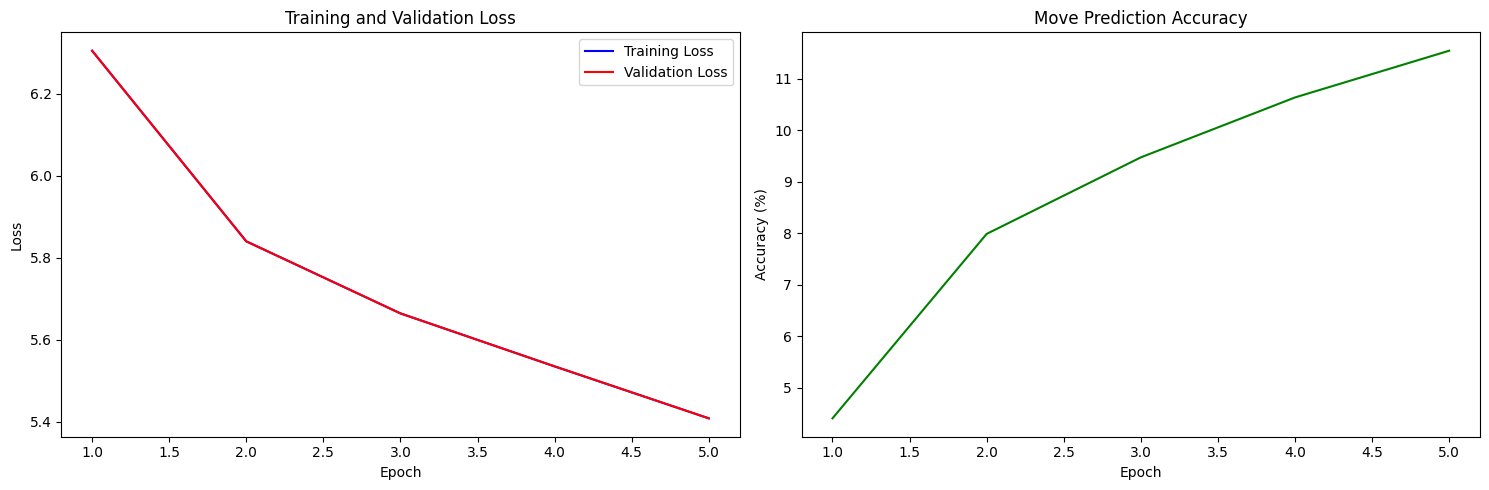

Epoch 5:
Loss = 5.4087, Accuracy = 11.54%
New best model saved with loss: 5.4087


Epoch 6/50: 100%|██████████| 771/771 [00:06<00:00, 118.78it/s, loss=4.4042]


New best model saved with loss: 5.2988


Epoch 7/50: 100%|██████████| 771/771 [00:06<00:00, 118.08it/s, loss=5.1608]


New best model saved with loss: 5.1953


Epoch 8/50: 100%|██████████| 771/771 [00:06<00:00, 126.43it/s, loss=5.9035]


New best model saved with loss: 5.0825


Epoch 9/50: 100%|██████████| 771/771 [00:06<00:00, 112.03it/s, loss=5.6275]


New best model saved with loss: 4.9819


Epoch 10/50: 100%|██████████| 771/771 [00:06<00:00, 126.87it/s, loss=4.7048]


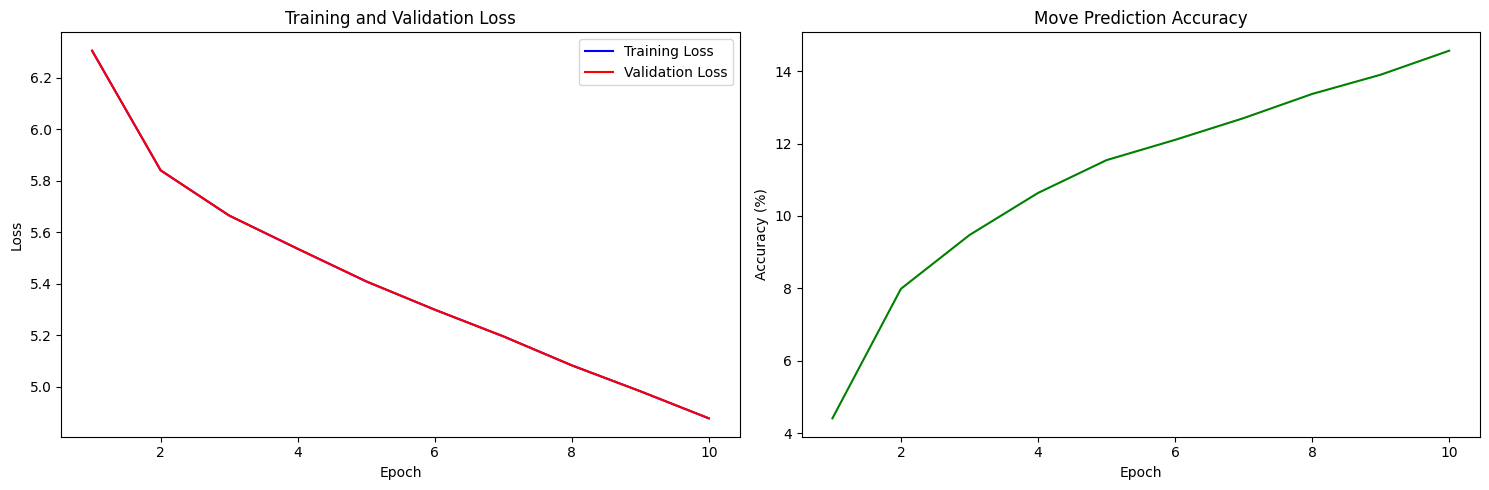

Epoch 10:
Loss = 4.8767, Accuracy = 14.56%
New best model saved with loss: 4.8767


Epoch 11/50: 100%|██████████| 771/771 [00:06<00:00, 116.04it/s, loss=5.0402]


New best model saved with loss: 4.7771


Epoch 12/50: 100%|██████████| 771/771 [00:07<00:00, 101.89it/s, loss=4.4504]


New best model saved with loss: 4.6883


Epoch 13/50: 100%|██████████| 771/771 [00:06<00:00, 118.88it/s, loss=3.7163]


New best model saved with loss: 4.5950


Epoch 14/50: 100%|██████████| 771/771 [00:06<00:00, 121.80it/s, loss=4.7010]


New best model saved with loss: 4.5001


Epoch 15/50: 100%|██████████| 771/771 [00:06<00:00, 110.91it/s, loss=5.0326]


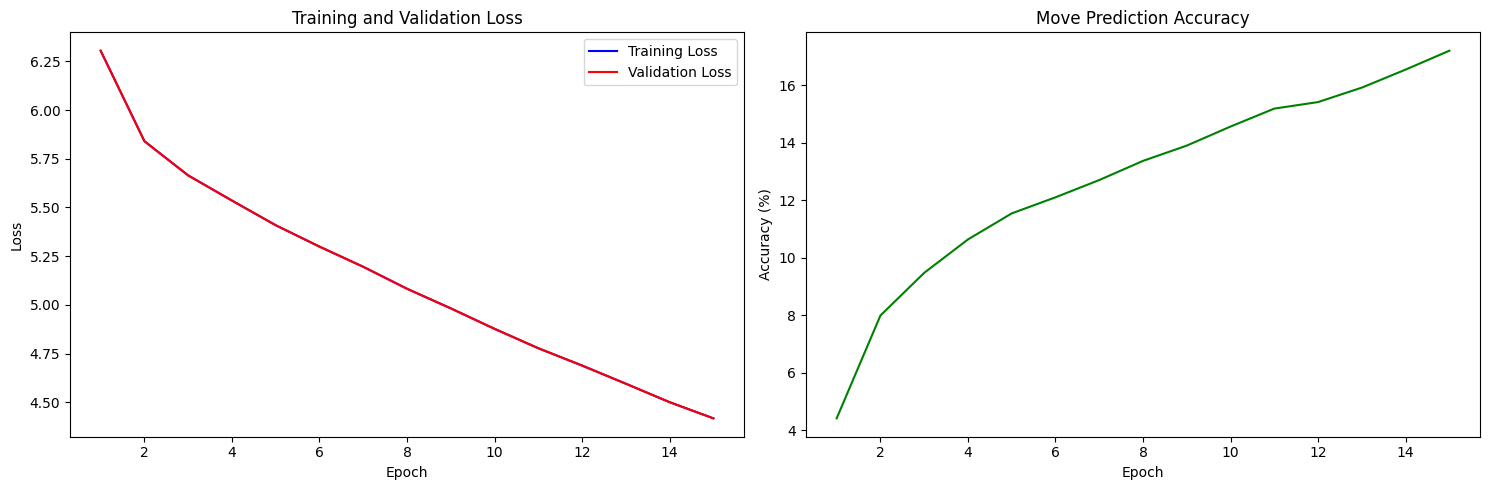

Epoch 15:
Loss = 4.4172, Accuracy = 17.20%
New best model saved with loss: 4.4172


Epoch 16/50: 100%|██████████| 771/771 [00:06<00:00, 123.06it/s, loss=3.7291]


New best model saved with loss: 4.3397


Epoch 17/50: 100%|██████████| 771/771 [00:07<00:00, 109.84it/s, loss=3.9899]


New best model saved with loss: 4.2629


Epoch 18/50: 100%|██████████| 771/771 [00:06<00:00, 114.78it/s, loss=4.0407]


New best model saved with loss: 4.1856


Epoch 19/50: 100%|██████████| 771/771 [00:06<00:00, 122.41it/s, loss=3.6103]


New best model saved with loss: 4.1164


Epoch 20/50: 100%|██████████| 771/771 [00:07<00:00, 108.41it/s, loss=4.8529]


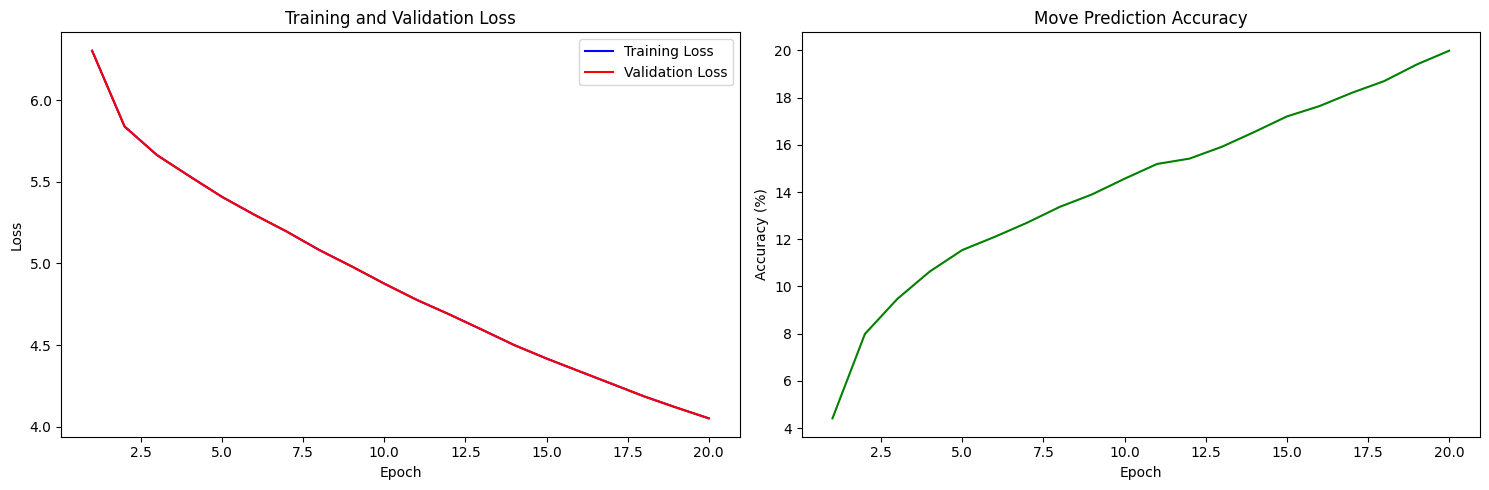

Epoch 20:
Loss = 4.0503, Accuracy = 19.99%
New best model saved with loss: 4.0503


Epoch 21/50: 100%|██████████| 771/771 [00:06<00:00, 120.44it/s, loss=4.2801]


New best model saved with loss: 3.9893


Epoch 22/50: 100%|██████████| 771/771 [00:06<00:00, 113.51it/s, loss=4.2625]


New best model saved with loss: 3.9309


Epoch 23/50: 100%|██████████| 771/771 [00:06<00:00, 110.52it/s, loss=3.7111]


New best model saved with loss: 3.8732


Epoch 24/50: 100%|██████████| 771/771 [00:06<00:00, 118.51it/s, loss=3.5941]


New best model saved with loss: 3.8183


Epoch 25/50: 100%|██████████| 771/771 [00:06<00:00, 111.81it/s, loss=3.5834]


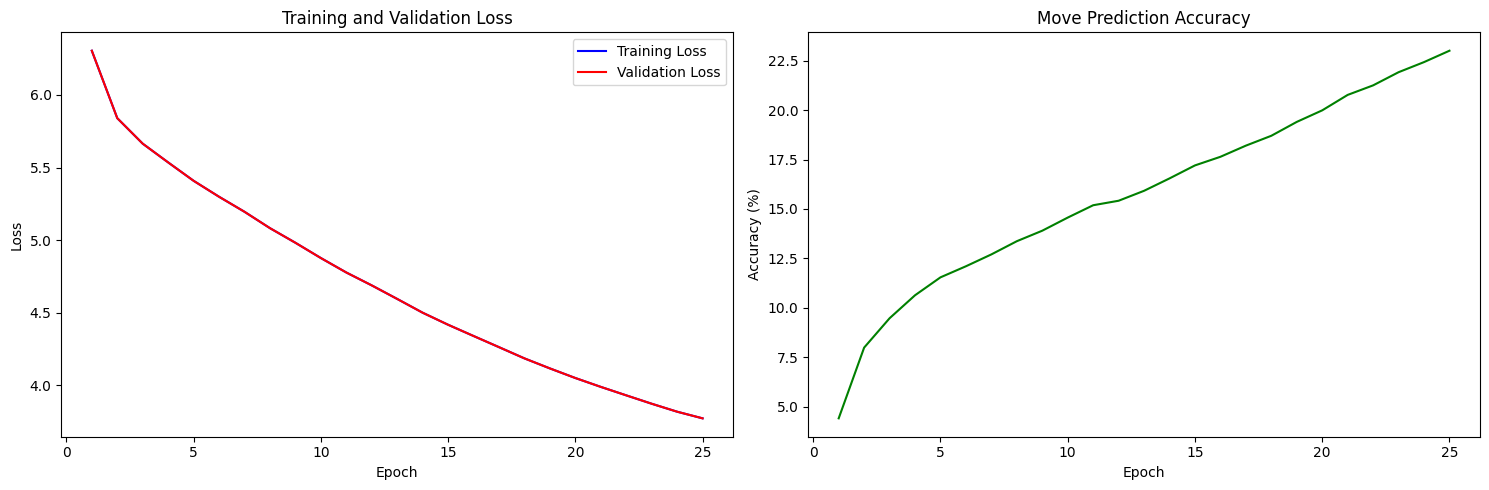

Epoch 25:
Loss = 3.7726, Accuracy = 23.00%
New best model saved with loss: 3.7726


Epoch 26/50: 100%|██████████| 771/771 [00:06<00:00, 114.79it/s, loss=2.8734]


New best model saved with loss: 3.7143


Epoch 27/50: 100%|██████████| 771/771 [00:06<00:00, 113.32it/s, loss=3.3740]


New best model saved with loss: 3.6669


Epoch 28/50: 100%|██████████| 771/771 [00:06<00:00, 110.58it/s, loss=3.7209]


New best model saved with loss: 3.6267


Epoch 29/50: 100%|██████████| 771/771 [00:06<00:00, 115.15it/s, loss=4.0650]


New best model saved with loss: 3.5845


Epoch 30/50: 100%|██████████| 771/771 [00:06<00:00, 117.02it/s, loss=3.5853]


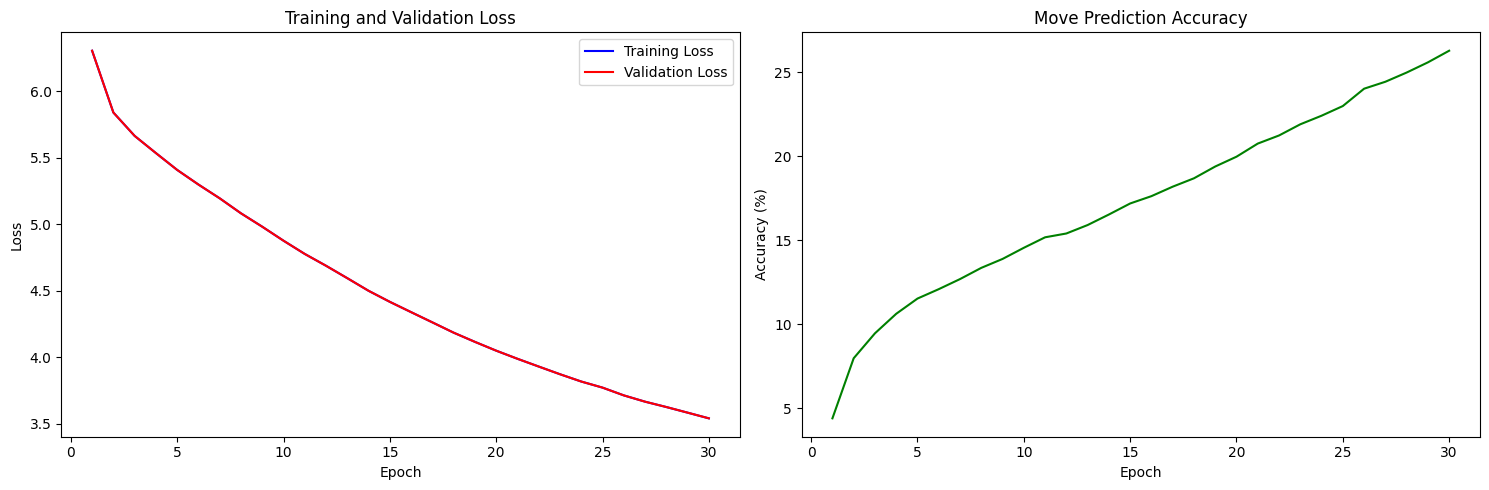

Epoch 30:
Loss = 3.5417, Accuracy = 26.30%
New best model saved with loss: 3.5417


Epoch 31/50: 100%|██████████| 771/771 [00:06<00:00, 112.99it/s, loss=3.8166]


New best model saved with loss: 3.5036


Epoch 32/50: 100%|██████████| 771/771 [00:06<00:00, 117.31it/s, loss=3.2899]


New best model saved with loss: 3.4684


Epoch 33/50: 100%|██████████| 771/771 [00:06<00:00, 118.70it/s, loss=3.8117]


New best model saved with loss: 3.4240


Epoch 34/50: 100%|██████████| 771/771 [00:06<00:00, 112.80it/s, loss=2.9222]


New best model saved with loss: 3.3867


Epoch 35/50: 100%|██████████| 771/771 [00:06<00:00, 115.47it/s, loss=3.1135]


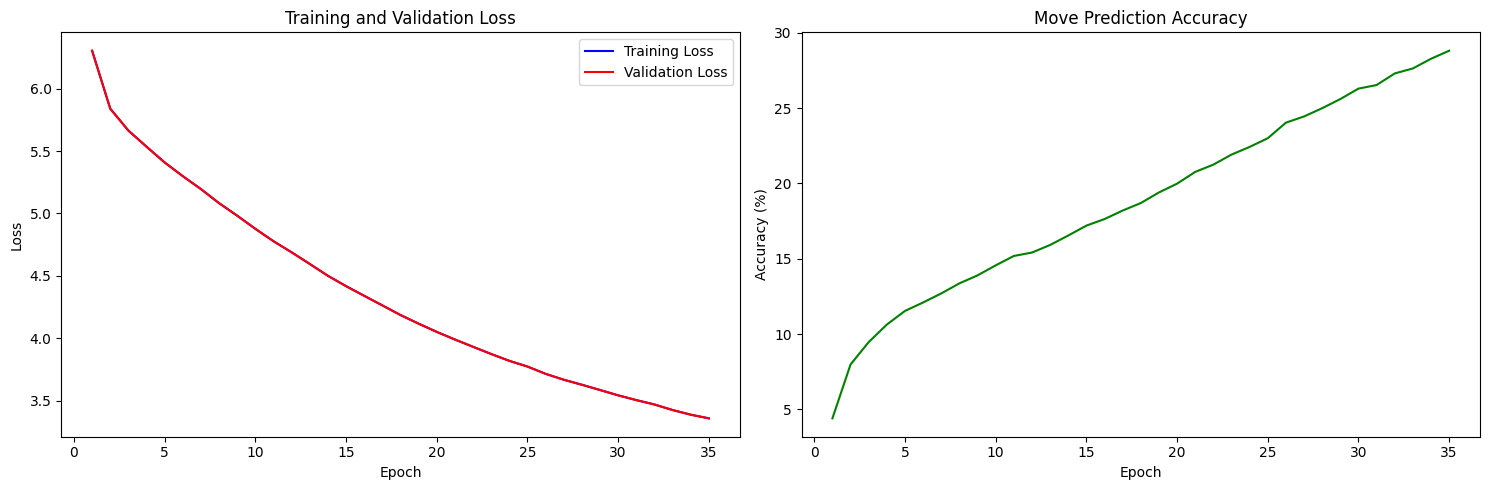

Epoch 35:
Loss = 3.3574, Accuracy = 28.81%
New best model saved with loss: 3.3574


Epoch 36/50: 100%|██████████| 771/771 [00:07<00:00, 109.71it/s, loss=3.4840]


New best model saved with loss: 3.3254


Epoch 37/50: 100%|██████████| 771/771 [00:06<00:00, 116.58it/s, loss=2.8096]


New best model saved with loss: 3.2883


Epoch 38/50: 100%|██████████| 771/771 [00:06<00:00, 110.53it/s, loss=4.3078]


New best model saved with loss: 3.2631


Epoch 39/50: 100%|██████████| 771/771 [00:06<00:00, 111.42it/s, loss=3.0091]


New best model saved with loss: 3.2345


Epoch 40/50: 100%|██████████| 771/771 [00:06<00:00, 114.41it/s, loss=3.0369]


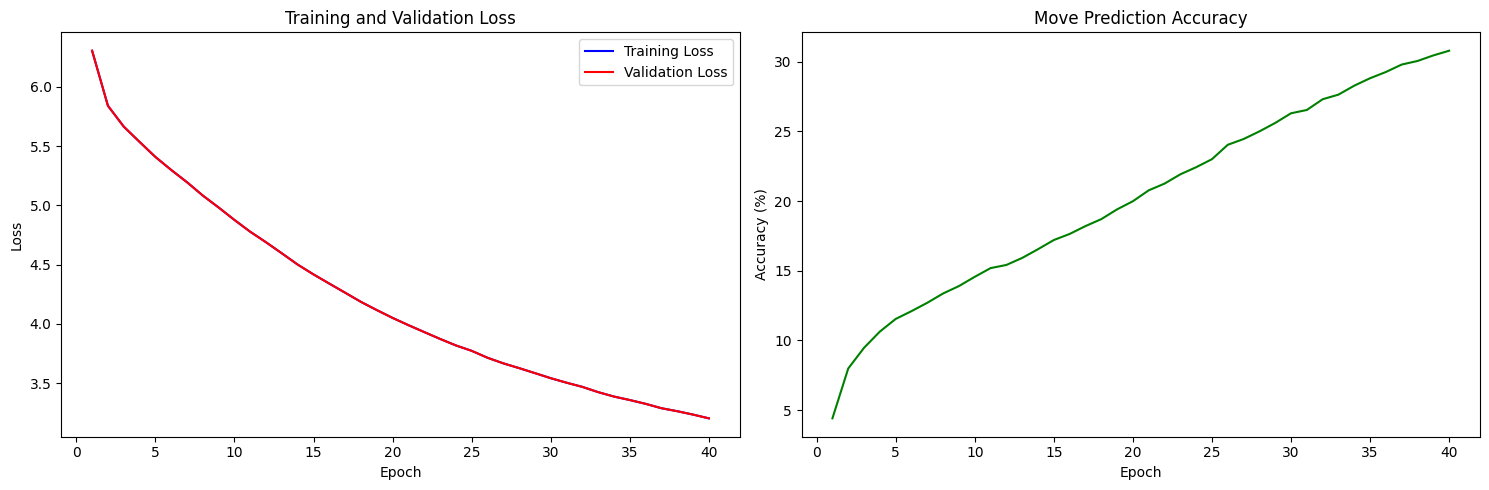

Epoch 40:
Loss = 3.2029, Accuracy = 30.79%
New best model saved with loss: 3.2029


Epoch 41/50: 100%|██████████| 771/771 [00:06<00:00, 116.73it/s, loss=2.6236]


New best model saved with loss: 3.1770


Epoch 42/50: 100%|██████████| 771/771 [00:06<00:00, 111.77it/s, loss=2.5705]


New best model saved with loss: 3.1514


Epoch 43/50: 100%|██████████| 771/771 [00:07<00:00, 108.03it/s, loss=4.1413]


New best model saved with loss: 3.1208


Epoch 44/50: 100%|██████████| 771/771 [00:06<00:00, 117.67it/s, loss=3.4821]


New best model saved with loss: 3.0963


Epoch 45/50: 100%|██████████| 771/771 [00:06<00:00, 111.52it/s, loss=3.8308]


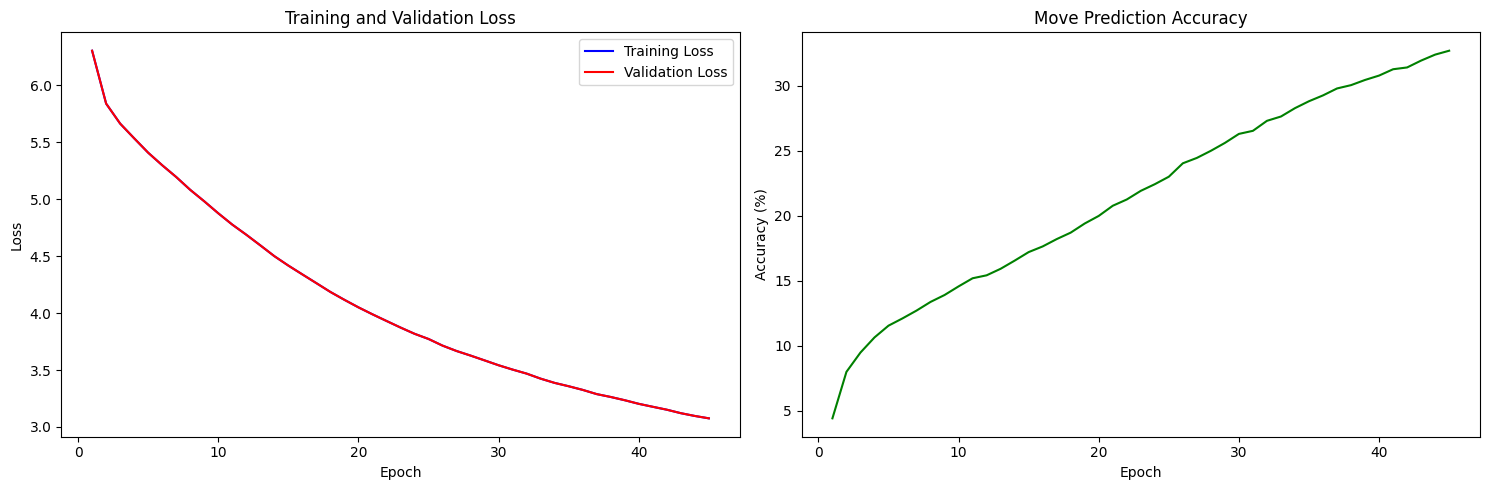

Epoch 45:
Loss = 3.0754, Accuracy = 32.70%
New best model saved with loss: 3.0754


Epoch 46/50: 100%|██████████| 771/771 [00:06<00:00, 114.62it/s, loss=2.7456]


New best model saved with loss: 3.0449


Epoch 47/50: 100%|██████████| 771/771 [00:07<00:00, 106.73it/s, loss=3.0668]


New best model saved with loss: 3.0280


Epoch 48/50: 100%|██████████| 771/771 [00:06<00:00, 113.36it/s, loss=2.8580]


New best model saved with loss: 3.0069


Epoch 49/50: 100%|██████████| 771/771 [00:06<00:00, 113.97it/s, loss=2.9092]


New best model saved with loss: 2.9778


Epoch 50/50: 100%|██████████| 771/771 [00:06<00:00, 113.62it/s, loss=2.6620]


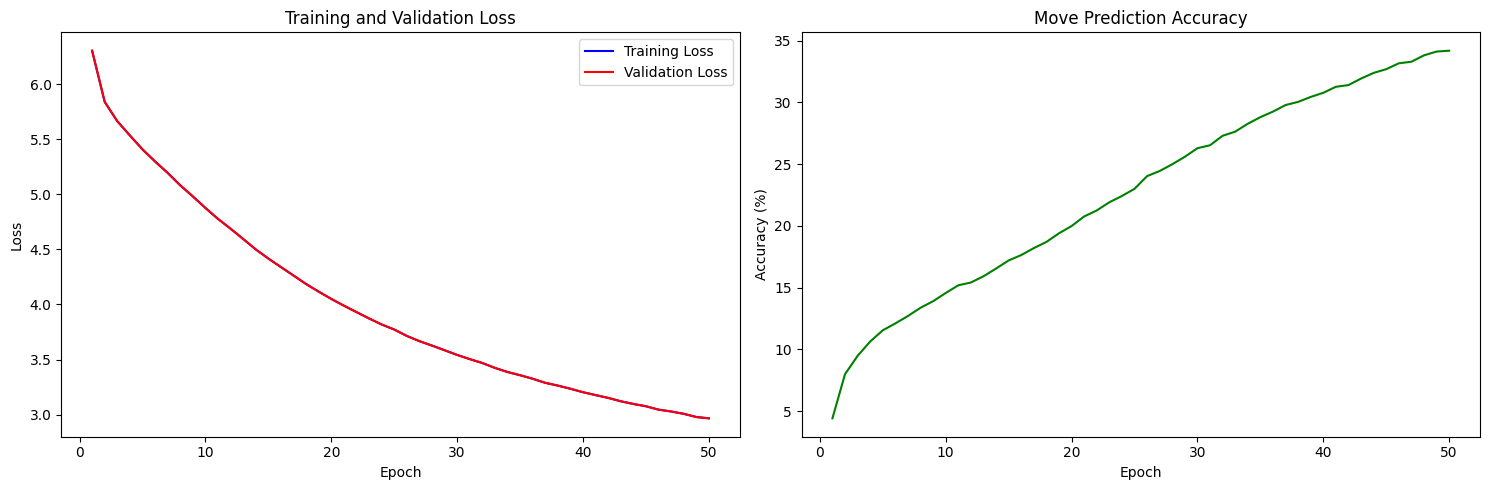

Epoch 50:
Loss = 2.9657, Accuracy = 34.19%
New best model saved with loss: 2.9657


In [ ]:
main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')